# ResNet
使用残差块的网络

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [10]:
class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, use_res=False, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        if use_res:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.conv3 = None
    
    def forward(self, x):
        y1 = F.relu(self.bn1(self.conv1(x)))
        y1 = self.bn2(self.conv2(y1))
        if self.conv3:
            y2 = self.conv3(x)
            y1 += y2
        y1 = F.relu(y1)
        return y1
    

In [13]:
def res_block(num_blocks, in_channels, out_channels, first_block=False):
    blk = []
    for i in range(num_blocks):
        if i == 0:
            if first_block:
                b = Residual(in_channels, out_channels, use_res=False)
            else:
                b = Residual(in_channels, out_channels, use_res=True, stride = 2)
        else:
            b = Residual(out_channels, out_channels, use_res=False)
        blk.append(b)
    return blk

In [14]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

b2 = nn.Sequential(*res_block(2, 64, 64, first_block=True))
b3 = nn.Sequential(*res_block(2, 64, 128))
b4 = nn.Sequential(*res_block(2, 128, 256))
b5 = nn.Sequential(*res_block(2, 256, 512))

net = nn.Sequential(
    b1, b2, b3, b4, b5, 
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(512, 10)
)

In [17]:
x = torch.randn((1, 1, 96, 96))
for layer in net:
    x = layer(x)
    print(x.shape)

torch.Size([1, 64, 24, 24])
torch.Size([1, 64, 24, 24])
torch.Size([1, 128, 12, 12])
torch.Size([1, 256, 6, 6])
torch.Size([1, 512, 3, 3])
torch.Size([1, 512, 1, 1])
torch.Size([1, 512])
torch.Size([1, 10])


loss 0.030, train acc 0.989, test acc 0.884
2069.3 examples/sec on cuda:0


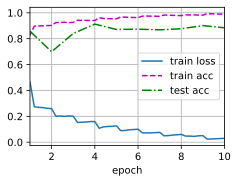

In [19]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, device=d2l.try_gpu())

loss 0.038, train acc 0.987, test acc 0.878
3768.9 examples/sec on cuda:0


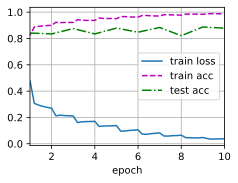

In [20]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, device=d2l.try_gpu())